<a href="https://colab.research.google.com/github/ArinaLazarenko/Out-of-Distribution-Detection/blob/main/ood_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Loading

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Load CIFAR-100 and CIFAR-10 test sets
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=32, shuffle=False)

testset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
loader_cifar100 = torch.utils.data.DataLoader(testset_cifar100, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 77.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 169M/169M [00:02<00:00, 80.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [4]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")
model = AutoModelForImageClassification.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Accuracy Check

In [5]:
from torch.nn.functional import softmax
from tqdm import tqdm

def compute_accuracy(model, dataloader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs.logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy

In [6]:
accuracy_cifar10 = compute_accuracy(model, loader_cifar10)
print(f"Accuracy on CIFAR-10 test set: {accuracy_cifar10:.2f}%")

100%|██████████| 313/313 [00:35<00:00,  8.72it/s]

Accuracy on CIFAR-10 test set: 95.12%


In [7]:
accuracy_cifar100 = compute_accuracy(model, loader_cifar100)
print(f"Accuracy on CIFAR-100 test set: {accuracy_cifar100:.2f}%")

100%|██████████| 313/313 [00:34<00:00,  9.05it/s]

Accuracy on CIFAR-100 test set: 0.97%


# Prediction samples

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.nn.functional import softmax

labels_cifar10 = testset_cifar10.classes

def show_samples_with_predictions(model, dataloader, labels_cifar, num_samples=5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect all images and labels from the dataloader
    all_images, all_labels = [], []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate to form a single dataset
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Select random indices
    total_samples = len(all_images)
    random_indices = random.sample(range(total_samples), num_samples)

    # Get random images and labels
    images = all_images[random_indices].to(device)
    labels = all_labels[random_indices].to(device)

    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs.logits, dim=1)

    # Plot the images and predictions
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions for plotting
    images = np.clip(images * 0.229 + 0.485, 0, 1)  # Unnormalize images

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {labels_cifar10[predictions[i]]}\nTrue: {labels_cifar[labels[i]]}")
        plt.axis('off')
    plt.show()

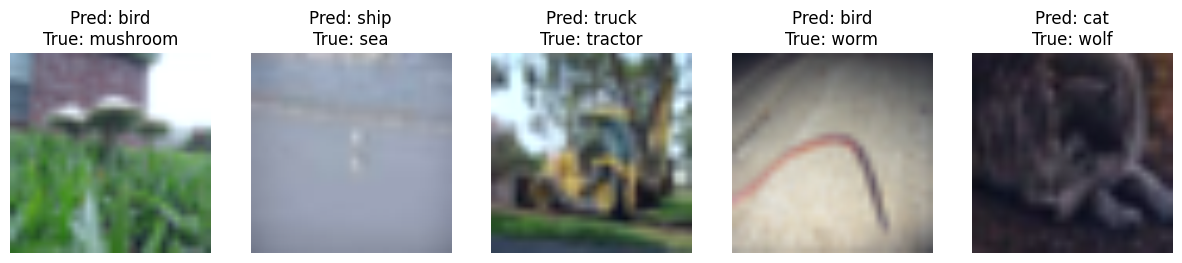

In [9]:
labels_cifar100 = testset_cifar100.classes
show_samples_with_predictions(model, loader_cifar100, labels_cifar100, num_samples=5)

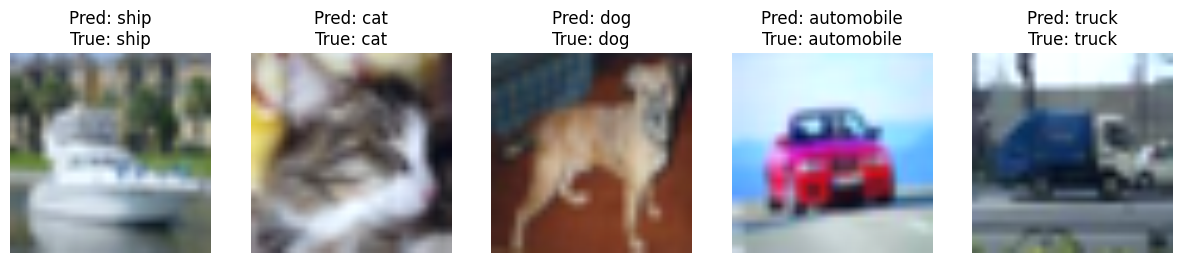

In [10]:
labels_cifar10 = testset_cifar10.classes
show_samples_with_predictions(model, loader_cifar10, labels_cifar10, num_samples=5)

# Softmax Scores Calculation

In [11]:
!pip install scikit-learn

In [12]:
from torch.nn.functional import softmax
from tqdm import tqdm

def get_softmax_scores(model, dataloader, num_samples=None):
    """Compute softmax max probabilities for a given dataset."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    softmax_scores = []
    softmax_labels = []
    true_false_labels = []

    with torch.no_grad():
        for i, (images, true_labels) in enumerate(dataloader):  # true_labels is provided by the dataloader
            if num_samples and i * dataloader.batch_size >= num_samples:
                break

            images = images.to(device)
            true_labels = true_labels.to(device)  # Move true labels to the same device as images

            outputs = model(images)
            # Use torch.nn.functional.softmax directly, and pass dim as an argument
            probs = softmax(outputs.logits, dim=1)

            # Get the maximum probability for each sample (confidence score)
            max_probs, max_indices = torch.max(probs, dim=1)
            softmax_scores.extend(max_probs.cpu().numpy())
            softmax_labels.extend(max_indices.cpu().numpy())

            # Check if the predictions are correct and append 1 for correct, 0 for incorrect
            correct_predictions = (max_indices == true_labels).cpu().numpy().astype(int)
            true_false_labels.extend(correct_predictions)

    return np.array(softmax_scores), softmax_labels, true_false_labels

In [13]:
# Collect softmax scores for CIFAR-10 (in-distribution)
softmax_scores_cifar10, softmax_labels_cifar10, true_false_labels_cifar10 = get_softmax_scores(model, loader_cifar10)

In [14]:
# Print the first 10 softmax scores for CIFAR-10
print("Softmax scores (CIFAR-10, in-distribution):")
print(softmax_scores_cifar10[:10])

Softmax scores (CIFAR-10, in-distribution):
[0.81257844 0.7576495  0.5840014  0.71051955 0.8389893  0.8193373
 0.5954621  0.81367916 0.811214   0.7709969 ]


In [15]:
print("Softmax labels (CIFAR-10, in-distribution):")
print(softmax_labels_cifar10[:10])

Softmax labels (CIFAR-10, in-distribution):
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


In [16]:
softmax_labels_names_n = [labels_cifar10[i] for i in softmax_labels_cifar10[:10]]
print(softmax_labels_names_n)

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [17]:
print("true / false values (CIFAR-10, in-distribution):")
print(true_false_labels_cifar10[:30])

true / false values (CIFAR-10, in-distribution):
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


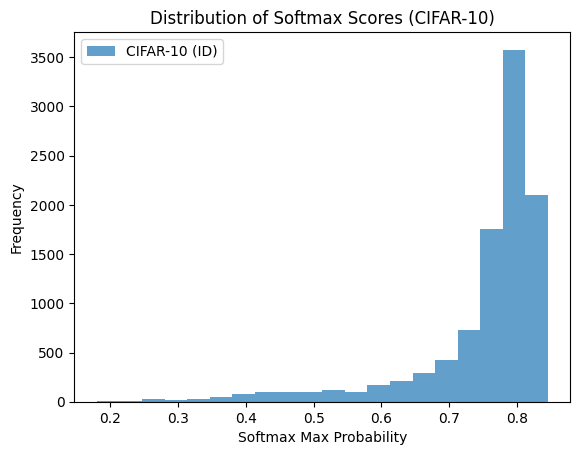

In [18]:
import matplotlib.pyplot as plt

plt.hist(softmax_scores_cifar10, bins=20, alpha=0.7, label='CIFAR-10 (ID)')
plt.xlabel('Softmax Max Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Scores (CIFAR-10)')
plt.legend()
plt.show()

In [19]:
# Collect softmax scores for CIFAR-100 (out-of-distribution)
softmax_scores_cifar100, softmax_labels_cifar100, true_false_labels_cifar100 = get_softmax_scores(model, loader_cifar100)
true_false_labels_cifar100 = [0] * len(true_false_labels_cifar100)

In [20]:
# Print the first 10 softmax scores for CIFAR-10
print("Softmax scores (CIFAR-100, out-of-distribution):")
print(softmax_scores_cifar100[:10])

Softmax scores (CIFAR-100, out-of-distribution):
[0.7158402  0.31949532 0.45261618 0.53822005 0.18522048 0.19870222
 0.5817115  0.60238147 0.33580527 0.23093076]


In [21]:
print("Softmax labels (CIFAR-100, out-of-distribution):")
print(softmax_labels_cifar100[:10])

Softmax labels (CIFAR-100, out-of-distribution):
[8, 2, 2, 2, 0, 2, 2, 3, 0, 2]


In [22]:
softmax_labels_names_n = [labels_cifar100[i] for i in softmax_labels_cifar100[:10]]
print(softmax_labels_names_n)

['bicycle', 'baby', 'baby', 'baby', 'apple', 'baby', 'baby', 'bear', 'apple', 'baby']


In [23]:
print("true / false values (CIFAR-100, out-of-distribution):")
print(true_false_labels_cifar100[:30])

true / false values (CIFAR-100, out-of-distribution):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


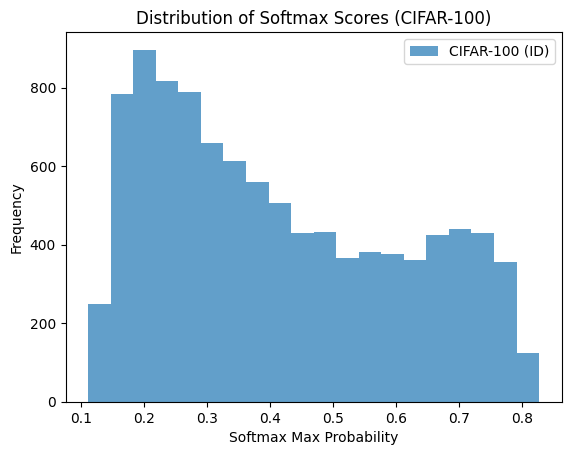

In [24]:
plt.hist(softmax_scores_cifar100, bins=20, alpha=0.7, label='CIFAR-100 (ID)')
plt.xlabel('Softmax Max Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Scores (CIFAR-100)')
plt.legend()
plt.show()

# Threshold Calculation

In [25]:
# softmax_scores_cifar10
# softmax_scores_cifar100
# softmax_labels_cifar10
# softmax_labels_cifar100
# true_false_labels_cifar10
# true_false_labels_cifar100

true_positive = []
false_positive = []

false_positive.extend(softmax_scores_cifar100)

for i in range(len(true_false_labels_cifar10)):
    if true_false_labels_cifar10[i] == 0:
        false_positive.append(softmax_scores_cifar10[i])
    else:  # If it's 1
        true_positive.append(softmax_scores_cifar10[i])

In [26]:
print(len(true_positive))
print(len(false_positive))

9512
10488


In [27]:
print(true_positive[:30])

[0.81257844, 0.7576495, 0.5840014, 0.71051955, 0.8389893, 0.8193373, 0.5954621, 0.81367916, 0.811214, 0.7709969, 0.8075084, 0.80636793, 0.75718296, 0.7616283, 0.8101117, 0.82313335, 0.741316, 0.8120425, 0.76099414, 0.8056752, 0.8039704, 0.6363248, 0.78312963, 0.7703212, 0.61675376, 0.73976713, 0.8064225, 0.8148243, 0.7832957, 0.8247491]


In [28]:
print(false_positive[:30])

[0.7158402, 0.31949532, 0.45261618, 0.53822005, 0.18522048, 0.19870222, 0.5817115, 0.60238147, 0.33580527, 0.23093076, 0.37976795, 0.67557967, 0.7395384, 0.38933262, 0.26728415, 0.60469025, 0.16680998, 0.7078307, 0.16237558, 0.19251442, 0.19402541, 0.37853205, 0.6125961, 0.33907422, 0.32749763, 0.24131837, 0.12044016, 0.1663112, 0.14623494, 0.3397838]


In [29]:
avg_true_positive = sum(true_positive) / len(true_positive) if len(true_positive) > 0 else 0

avg_false_positive = sum(false_positive) / len(false_positive) if len(false_positive) > 0 else 0

print(f"Average True Positive: {avg_true_positive}")
print(f"Average False Positive: {avg_false_positive}")

Average True Positive: 0.7622453961129746
Average False Positive: 0.41910695889716065


In [30]:
threshold = (avg_true_positive + avg_false_positive) / 2
print(f"Threshold: {threshold:.2f}")

Threshold: 0.59


# AUROC Calculation

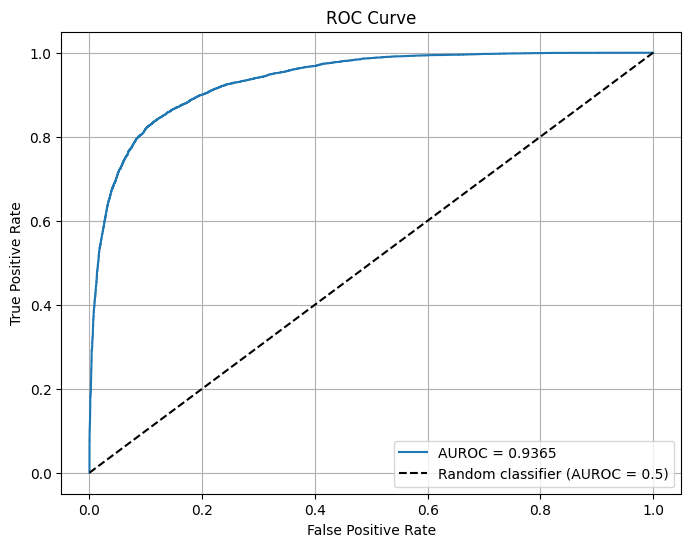

AUROC Score: 0.9365


In [31]:
from sklearn.metrics import roc_curve, auc

auroc_labels = [1] * len(softmax_scores_cifar10) + [0] * len(softmax_scores_cifar100)
auroc_scores = np.concatenate([softmax_scores_cifar10, softmax_scores_cifar100])

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(auroc_labels, auroc_scores)

# Calculate AUROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUROC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUROC Score: {roc_auc:.4f}")

# Confusion Matrix

In [58]:
y_true = []
y_pred = []

# CIFAR-10: in-distribution
for i in range(len(softmax_scores_cifar10)):
    y_true.append(1)
    correct = int(true_false_labels_cifar10[i] == 1)  # True if predicted correctly
    y_pred.append(correct)  # 1 for correct, 0 for incorrect

# CIFAR-100: out-of-distribution
for i in range(len(softmax_scores_cifar100)):
    y_true.append(0)
    correct = int(not (softmax_scores_cifar100[i] < 0.59))  # Correct if score < 0.59 (OOD correctly detected)
    y_pred.append(correct)  # 1 for correct, 0 for incorrect

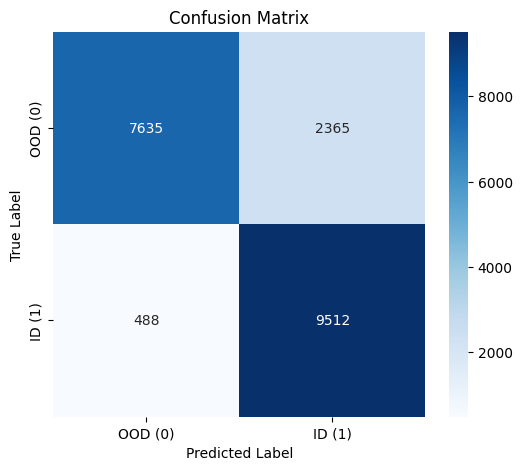

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['OOD (0)', 'ID (1)'], yticklabels=['OOD (0)', 'ID (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# F1 metric

In [60]:
# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()

# Precision
precision = TP / (TP + FP)

# Recall
recall = TP / (TP + FN)

# F1 Score
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8009
Recall: 0.9512
F1 Score: 0.8696


# OOD Detection

In [61]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_samples_with_predictions_ood(model, dataloader, labels_cifar, num_samples=5, threshold=0.59):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect all images and labels from the dataloader
    all_images, all_labels = [], []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate to form a single dataset
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Select random indices
    total_samples = len(all_images)
    random_indices = random.sample(range(total_samples), num_samples)

    # Get random images and labels
    images = all_images[random_indices].to(device)
    labels = all_labels[random_indices].to(device)

    with torch.no_grad():
        outputs = model(images)
        softmax_scores = torch.softmax(outputs.logits, dim=1)
        max_scores, predictions = torch.max(softmax_scores, dim=1)

    # Determine if the predictions are OOD or not
    is_ood = max_scores < threshold  # OOD if the maximum score is lower than the threshold

    # Plot the images, predictions, and OOD labels
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions for plotting
    images = np.clip(images * 0.229 + 0.485, 0, 1)  # Unnormalize images

    rows = (num_samples + 4) // 5  # This ensures at least 1 row for 5 images

    plt.figure(figsize=(15, 5 * rows))
    for i in range(num_samples):
        row = i // 5
        col = i % 5
        plt.subplot(rows, 5, i + 1)
        plt.imshow(images[i])

        # Display OOD label if applicable, including the prediction score
        if is_ood[i]:
            plt.title(f"Pred: OOD\nTrue: {labels_cifar[labels[i]]}\nScore: {max_scores[i]:.3f}")
        else:
            plt.title(f"Pred: {labels_cifar10[predictions[i]]}\nTrue: {labels_cifar[labels[i]]}\nScore: {max_scores[i]:.3f}")

        plt.axis('off')

    plt.show()

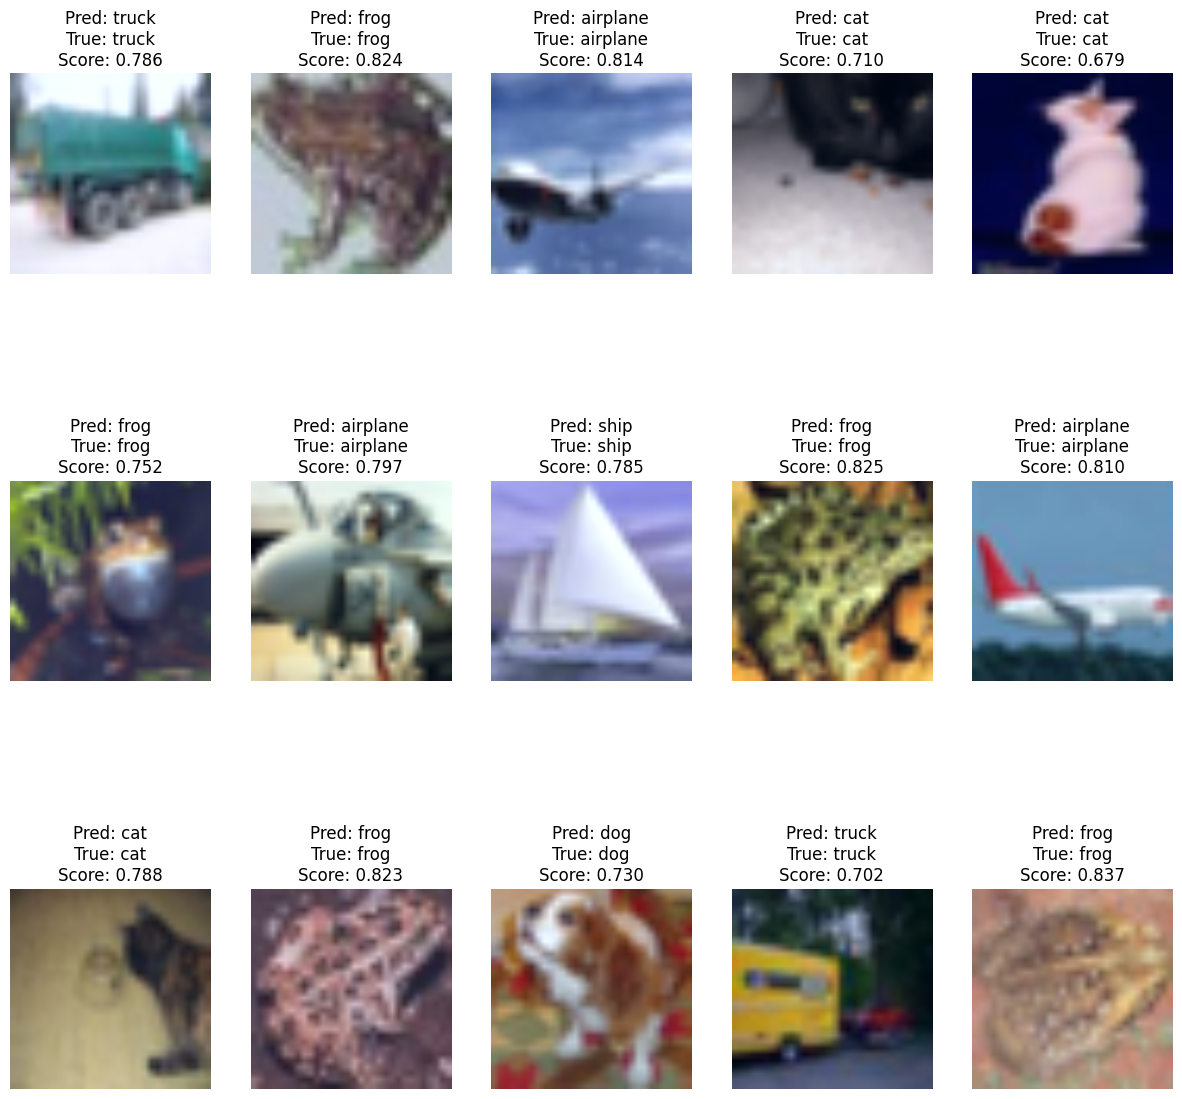

In [62]:
show_samples_with_predictions_ood(model, loader_cifar10, labels_cifar10, num_samples=15)

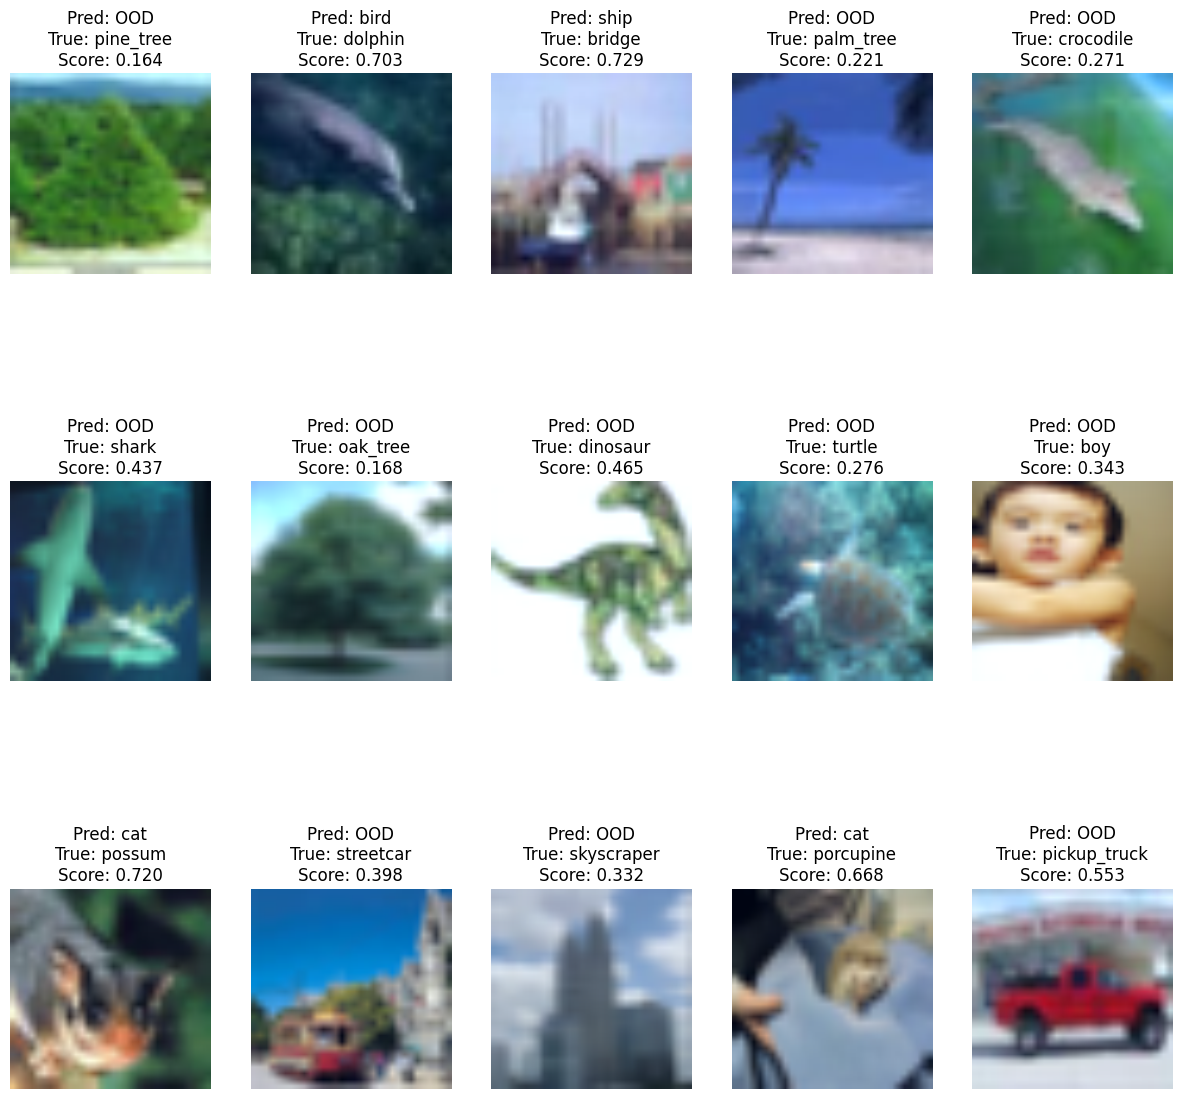

In [63]:
show_samples_with_predictions_ood(model, loader_cifar100, labels_cifar100, num_samples=15)